In [1]:
# Importing necessary packages
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm

In [2]:
# 1.) Defining the 27 Power-Variance players
players = [
    "Oneil_Cruz", "James_Wood", "Ryan_McMahon", "Riley_Greene",
    "Eugenio_Suárez", "Elly_De_La_Cruz", "Kyle_Schwarber", "Jo_Adell",
    "Teoscar_Hernández", "Spencer_Torkelson", "Lawrence_Butler",
    "Randy_Arozarena", "Adolis_García", "Jazz_Chisholm_Jr",
    "Christian_Walker", "Michael_Busch", "Willy_Adames", "Taylor_Ward",
    "Rafael_Devers", "Brent_Rooker", "Zach_Neto", "Matt_Olson",
    "Marcell_Ozuna", "Ian_Happ", "Pete_Crow-Armstrong",
    "Pete_Alonso", "Shea_Langeliers"
]

In [3]:
# 2.) Setting a parquet directory path
parquet_dir = r"C:\Users\andre\Documents\Documents\Syracuse\JUNIOR YEAR\SPRING 2026\SAL 358\SABR26\Simulations\output"

In [4]:
# 3.) Load only needed columns, filter to feasible rows per file
cols_needed = ["player_name", "base_state_name", "outs", "count",
               "score_diff", "inning", "wp_diff_from_baseline",
               "feasibility_density", "is_feasible"]

feasible_dfs = []
missing = []

for player in players:
    path = os.path.join(parquet_dir, f"{player}_simulation.parquet")
    if os.path.exists(path):
        df = pd.read_parquet(path, columns=cols_needed)
        df = df[df["is_feasible"] == 1]
        df["player"] = player.replace("_", " ")
        feasible_dfs.append(df)
    else:
        missing.append(player)

if missing:
    print(f"⚠ Missing parquet files for: {missing}")
else:
    print("✓ All 27 parquet files loaded successfully")

feasible = pd.concat(feasible_dfs, ignore_index=True)
print(f"✓ feasible loaded: {len(feasible):,} rows")

✓ All 27 parquet files loaded successfully
✓ feasible loaded: 33,929,280 rows


In [ ]:

# ------------------------------------------ PLOTS ---------------------------------------------------------------------------------------------------


In [5]:
os.chdir(r"C:\Users\andre\Documents\Documents\Syracuse\JUNIOR YEAR\SPRING 2026\SAL 358\SABR26\Plots")

In [14]:
# Color scales
syr_cmap = mcolors.LinearSegmentedColormap.from_list("syracuse", ["#f76900", "#000e54"])
good_bad_cmap = "RdYlGn"

TITLE_KW = dict(fontsize=16, fontweight="bold", ha="center")
LABEL_KW = dict(fontsize=13, fontweight="bold")

def fmt_ax(ax, title, xlabel=None, ylabel=None):
    ax.set_title(title, **TITLE_KW)
    if xlabel: ax.set_xlabel(xlabel, **LABEL_KW)
    if ylabel: ax.set_ylabel(ylabel, **LABEL_KW)

def save(name):
    plt.tight_layout()
    plt.savefig(f"{name}.png", dpi=300, bbox_inches="tight")
    plt.show()

In [15]:
# Define sac-fly eligible states
# Runner on 3B with < 2 outs: base_state_name contains "3B" and outs < 2
sac_fly_states = ["3B", "1B-3B", "2B-3B", "Bases Loaded"]

feasible["sac_fly_eligible"] = (
    feasible["base_state_name"].str.contains("3B", na=False) |
    (feasible["base_state_name"] == "loaded")
) & (feasible["outs"] < 2)

sac     = feasible[feasible["sac_fly_eligible"]]
non_sac = feasible[~feasible["sac_fly_eligible"]]

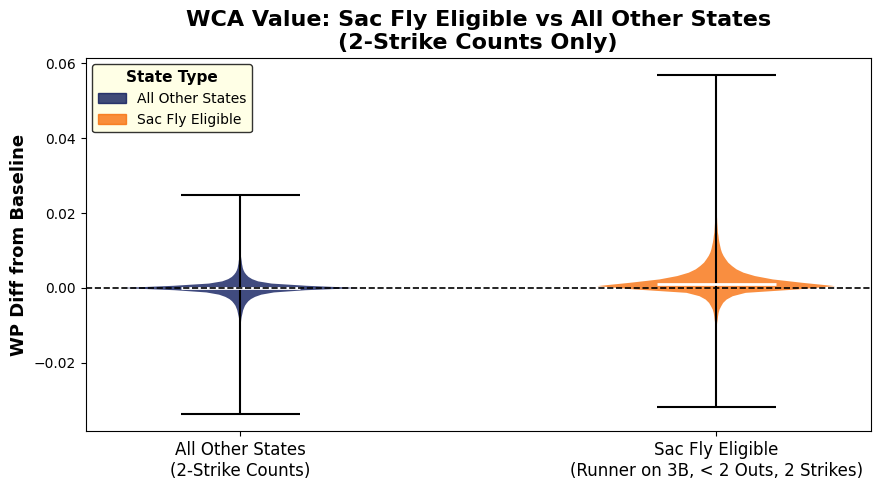

<Figure size 640x480 with 0 Axes>

In [16]:
# PLOT 1: WP DIFF — Sac Fly Eligible vs All Other States (on 2 strikes)
# Shows the overall WCA value is highest in sac fly situations (2 strike counts only)
# =============================================================================
sac_2strike = sac[sac["count"].str.endswith("-2")]
non_sac_2strike = non_sac[non_sac["count"].str.endswith("-2")]

fig, ax = plt.subplots(figsize=(9, 5))

data_violin = [
    non_sac_2strike["wp_diff_from_baseline"].dropna().sample(50000, random_state=42),
    sac_2strike["wp_diff_from_baseline"].dropna().sample(min(50000, len(sac_2strike)), random_state=42)
]

vp = ax.violinplot(data_violin, positions=[1, 2], showmedians=True, showmeans=False)

for i, (body, color) in enumerate(zip(vp["bodies"], ["#000e54", "#f76900"])):
    body.set_facecolor(color)
    body.set_alpha(0.75)
vp["cmedians"].set_color("white")
vp["cmedians"].set_linewidth(2)
for part in ["cbars", "cmins", "cmaxes"]:
    vp[part].set_color("black")

ax.axhline(0, color="black", linewidth=1.2, linestyle="--")
ax.set_xticks([1, 2])
ax.set_xticklabels(["All Other States\n(2-Strike Counts)", 
                    "Sac Fly Eligible\n(Runner on 3B, < 2 Outs, 2 Strikes)"], fontsize=12)
fmt_ax(ax, "WCA Value: Sac Fly Eligible vs All Other States\n(2-Strike Counts Only)",
       None, "WP Diff from Baseline")

patch1 = mpatches.Patch(color="#000e54", alpha=0.75, label="All Other States")
patch2 = mpatches.Patch(color="#f76900", alpha=0.75, label="Sac Fly Eligible")
legend = ax.legend(handles=[patch1, patch2], fontsize=10,
                   facecolor="lightyellow", edgecolor="black",
                   title="State Type", title_fontsize=11)
legend.get_title().set_fontweight("bold")
plt.tight_layout()
plt.savefig("sac_fly_violin.png", dpi=300, bbox_inches="tight")
plt.show()

save("sac_fly_violin")

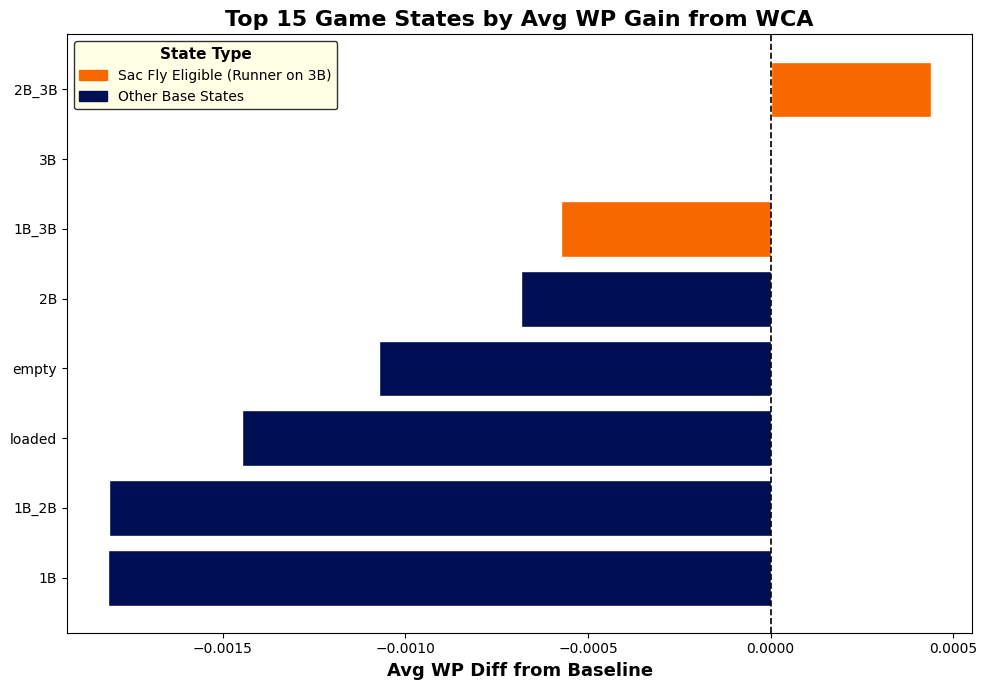

In [17]:
# PLOT 2: TOP 15 GAME STATES BY AVG WP DIFF — sac fly states highlighted
# Shows that sac fly states dominate the top game states for WCA value

state_wp = (feasible.groupby("base_state_name")["wp_diff_from_baseline"]
            .mean().reset_index()
            .sort_values("wp_diff_from_baseline", ascending=False)
            .head(15))

state_wp["sac_fly"] = state_wp["base_state_name"].str.contains("3B", na=False)
colors = ["#f76900" if s else "#000e54" for s in state_wp["sac_fly"]]

fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.barh(state_wp["base_state_name"][::-1],
               state_wp["wp_diff_from_baseline"][::-1],
               color=colors[::-1], edgecolor="white")
ax.axvline(0, color="black", linewidth=1.2, linestyle="--")
fmt_ax(ax, "Top 15 Game States by Avg WP Gain from WCA",
       "Avg WP Diff from Baseline", None)

patch_sac = mpatches.Patch(color="#f76900", label="Sac Fly Eligible (Runner on 3B)")
patch_oth = mpatches.Patch(color="#000e54", label="Other Base States")
legend = ax.legend(handles=[patch_sac, patch_oth], fontsize=10,
                   facecolor="lightyellow", edgecolor="black",
                   title="State Type", title_fontsize=11)
legend.get_title().set_fontweight("bold")

save("sac_fly_top_states")

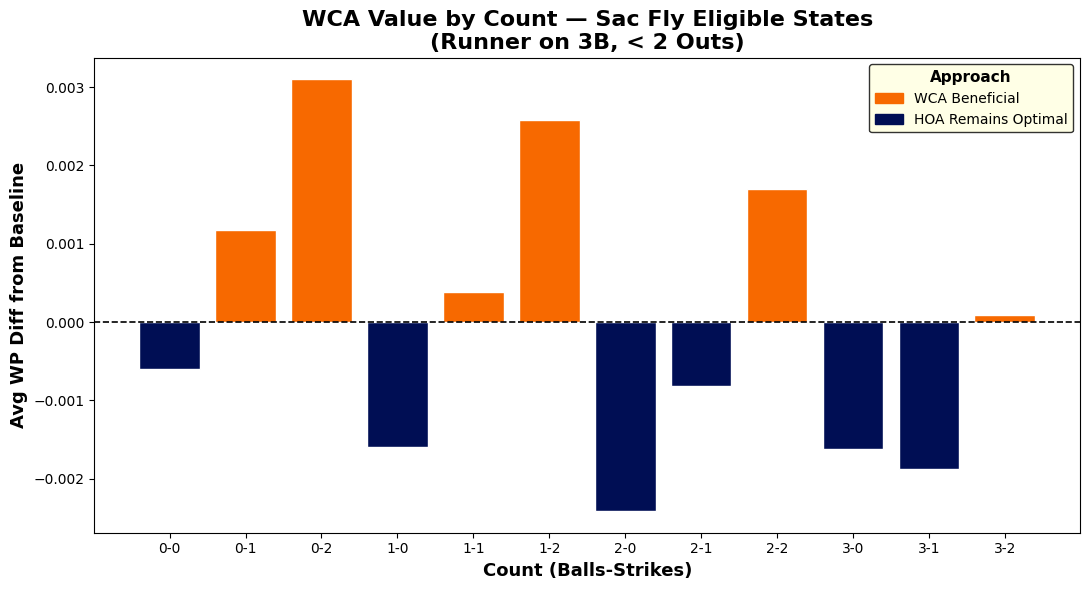

In [18]:
# PLOT 3: SAC FLY ELIGIBLE — WP DIFF BY COUNT
# Shows which counts within sac fly situations are most valuable for WCA

count_order = ["0-0","0-1","0-2","1-0","1-1","1-2",
               "2-0","2-1","2-2","3-0","3-1","3-2"]

sac_count = (sac.groupby("count")["wp_diff_from_baseline"]
             .mean().reset_index())
sac_count["count"] = pd.Categorical(sac_count["count"],
                                     categories=count_order, ordered=True)
sac_count = sac_count.sort_values("count")
sac_count["color"] = ["#f76900" if v > 0 else "#000e54"
                       for v in sac_count["wp_diff_from_baseline"]]

fig, ax = plt.subplots(figsize=(11, 6))
ax.bar(sac_count["count"], sac_count["wp_diff_from_baseline"],
       color=sac_count["color"], edgecolor="white")
ax.axhline(0, color="black", linewidth=1.2, linestyle="--")
fmt_ax(ax, "WCA Value by Count — Sac Fly Eligible States\n(Runner on 3B, < 2 Outs)",
       "Count (Balls-Strikes)", "Avg WP Diff from Baseline")

patch_pos = mpatches.Patch(color="#f76900", label="WCA Beneficial")
patch_neg = mpatches.Patch(color="#000e54", label="HOA Remains Optimal")
legend = ax.legend(handles=[patch_pos, patch_neg], fontsize=10,
                   facecolor="lightyellow", edgecolor="black",
                   title="Approach", title_fontsize=11)
legend.get_title().set_fontweight("bold")

save("sac_fly_by_count")

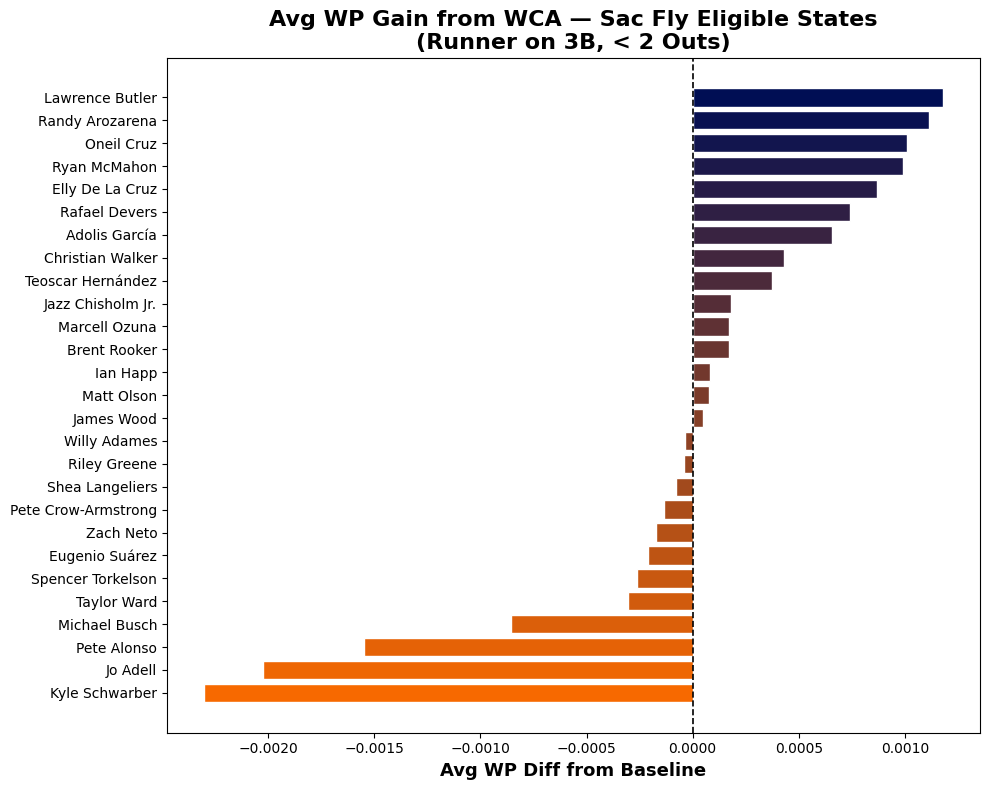

In [19]:
# PLOT 4: PER-PLAYER WP DIFF IN SAC FLY STATES
# Shows which PV hitters benefit most from WCA specifically in sac fly situations

player_sac = (sac.groupby("player_name")["wp_diff_from_baseline"]
              .mean().reset_index()
              .sort_values("wp_diff_from_baseline", ascending=True))

n = len(player_sac)
colors_sac = [mcolors.to_hex(syr_cmap(i / (n - 1))) for i in range(n)]

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(player_sac["player_name"], player_sac["wp_diff_from_baseline"],
        color=colors_sac, edgecolor="white")
ax.axvline(0, color="black", linewidth=1.2, linestyle="--")
fmt_ax(ax, "Avg WP Gain from WCA — Sac Fly Eligible States\n(Runner on 3B, < 2 Outs)",
       "Avg WP Diff from Baseline", None)
ax.tick_params(axis="y", labelsize=10)

save("sac_fly_by_player")